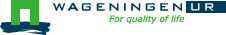



<h1>Applying sensitivity analysis to WOFOST</h1>

Sensitivity analysis is the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs (<a href="https://en.wikipedia.org/wiki/Sensitivity_analysis">Wikipedia</a>). The sensitivity of each input is often represented by a numeric value, called the sensitivity index.

In this notebook we demonstrate how to run a sensitivity analysis for the WOFOST model for a number of important parameters. The problem with WOFOST is that the sensitivity of the model can differ for different crops and regions depending on whether you are close to certain thresholds in the model. Therefore it is more useful to provide a general guideline for sensitivity analysis through this notebook rather than predefined set of sensitive parameters.

A limitation of this notebook is that is only applies for the scalar parameters in WOFOST. WOFOST also has a number of tabular parameters which are defined as as a function of development stage or temperature. The sensitivity of these parameters cannot be properly analyzed with the approach used in this notebook.

Below the WOFOST model is run for a sugar beet crop in the Netherlands and then sensitivity analysis is applied. The target variable for sensitivity is the total weight of the storage organs (TWSO) which represents the crop yield. However, other variables could be choosen as well such as total crop biomass or maximum leaf area index.

*Steven Hoek and Allard de Wit, Wageningen Environmental Sciences, June 2020*

## Dependencies for running this notebook
This notebook require the following package to be installed:
- [PCSE](https://pcse.readthedocs.io/en/stable/) and its dependencies (numpy, pandas, PyYAML, SQLAlchemy,...)
- [SAlib](https://salib.readthedocs.io/en/latest/)
- [IPython](http://ipython.org/)


In [155]:
import sys, os.path

import yaml
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 250)

import pcse
from pcse.models import Wofost71_PP
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLCropDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
from progressbar import printProgressBar

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.4.2


## WOFOST parameters
The table below gives an overview of important scalar WOFOST parameters related to the potential production situation.

In [154]:
df = pd.read_excel("ScalarParametersOfWofost-Potential.xlsx")
display(df)

,Name,Typical Value,Category,Description,Unit
0,CFET,1.000,Water use,correction factor for evapotranspiration,-
1,CVL,0.720,Conversion of assimilates into biomass,efficiency conversion of assimilates into leaf dry matter,kg / kg
2,CVO,0.820,Conversion of assimilates into biomass,efficiency conversion of assimilates into storage organ dry matter,kg / kg
3,CVR,0.720,Conversion of assimilates into biomass,efficiency conversion of assimilates into root dry matter,kg / kg
4,CVS,0.690,Conversion of assimilates into biomass,efficiency conversion of assimilates into stem dry matter,kg / kg
5,DLC,16.000,Phenology,critical day length for development (lower threshold),hours
6,DLO,8.000,Phenology,optimum day length for development,hours
7,PERDL,0.030,Death rates,max. relative death rate of leaves due to water stress,-
8,Q10,2.000,Maintenance respiration,increase of the respiration rate per 10 °C temperature increase,-
9,RDI,10.000,Water use,initial rooting depth,cm


## Settings for crop and location
In the following, standard data are used to run the WOFOST model for sugarbeet in the Netherlands. Feel free to carry out this sensitivity analysis for a different crop and / or a different location.

In [127]:
# Define location, crop and season
latitude = 52.0
longitude = 5.0
crop_name = 'sugarbeet'
variety_name = 'Sugarbeet_601'
campaign_start_date = '2006-01-01'
emergence_date = "2006-03-31"
harvest_date = "2006-10-20"
max_duration = 300

## Constructing the cropping calendar

In [128]:
# Here we define the agromanagement for sugar beet
agro_yaml = """
- {start}:
    CropCalendar:
        crop_name: {cname}
        variety_name: {vname}
        crop_start_date: {startdate}
        crop_start_type: emergence
        crop_end_date: {enddate}
        crop_end_type: harvest
        max_duration: {maxdur}
    TimedEvents: null
    StateEvents: null
""".format(cname=crop_name, vname=variety_name, 
           start=campaign_start_date, startdate=emergence_date, 
           enddate=harvest_date, maxdur=max_duration)
agro = yaml.safe_load(agro_yaml)
print(agro_yaml)


- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_601
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null



## Retrieving weather input and model parameters

In [129]:
# Weather data for Netherlands
wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)

# Parameter sets for crop, soil and site
# Standard crop parameter library
cropd = YAMLCropDataProvider()
# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()
# Some site parameters
sited = WOFOST71SiteDataProvider(WAV=50, CO2=360.)

# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agro[0])[0]
cropcalendar = agro[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

## Defining the analysis
Sensitivity analysis involves that we vary the model parameters a bit, to see how sensitive the model is to inaccuracies / variations in those values. We focus on variations in the model parameters and not on inaccuracies in e.g. rainfall figures. 

In the following, intervals are defined for parameters. It is necessary to acquire knowledge of what are realistic values for the parameters which is often crop specific.

In [130]:
# Define the target variable
target_variable = "TWSO"

# For each scalar parameter, determine a sensible interval 
problem_yaml = """
    num_vars: 5
    names: 
    - TSUM1
    - TSUM2
    - SPAN
    - Q10
    - TDWI
    bounds:
    - [500, 800]
    - [1200, 1600]
    - [28, 37]
    - [1.8, 2.2]
    - [0.4, 0.6]
"""
problem = yaml.safe_load(problem_yaml)

## First and second order sensitivities
When running a sensitivity analysis, we may compute first and second order sensitivities. Calculating second order sensitivities may require a large number of models runs if the number of parameters is large.

In this examples we use the Saltelli sampler to sample a number of combinations of parameter values and we will derive first and second order sensitivity. The variable `nsamples` indicates the number of samples to generate, higher values will provide better estimates of sensitivity but increase computation time.

In [131]:
calc_second_order = True
nsamples = 50
paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)
print("We are going to do %s simulations" % len(paramsets))

We are going to do 600 simulations


## Running the model
Below we are going to loop over the parameter sets sampled by the Saltelli sampler.

In [157]:
nsets = len(paramsets)
printProgressBar(0, nsets, prefix = 'Progress:', suffix = 'Complete', length = 50)

# Loop over the samples of the parameter values and run WOFOST for each of the samples
target_results = []
for i, paramset in enumerate(paramsets):
    params.clear_override()
    for name, value in zip(problem["names"], paramset):
        params.set_override(name, value)
    wofost = Wofost71_PP(params, wdp, agro)
    wofost.run_till_terminate()
    r = wofost.get_summary_output()
    target_result = r[0][target_variable]
    if target_result is None:
        print("Target variable is not available in summary output!")
        break
    target_results.append(target_result)
    printProgressBar(i+1, nsets, prefix = 'Progress:', suffix = 'Complete', length = 50)

target_results = np.array(target_results)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


# Computing sensitivity indices
We will use the [Sobol](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) method to assess the response of the model to the variations in the parameters. Besides Sobol, other known methods are Morris and FAST. See also: https://salib.readthedocs.io/en/latest/.

In [133]:
# Use the Sobol method to analyse the results of the simulations
Si = sobol.analyze(problem, target_results, calc_second_order=calc_second_order)

## Plotting results
After running the cell below, a chart with first order and total order sensitivity is drawn. The first order  sensitivity index for a parameter represents the fraction of the variance in the target variable caused by the variation in the input parameter. Total order indices represent the total variance in the target variable for a given parameter, including all variance caused by its interactions, of any order, with any other input variable. 

In many models there are statistical dependencies between parameters or physical constraints on the model. In such cases part of the variance in the output is also caused by interactions between variables which is not represented by the first order indices. In such cases, second order indices need to be calculated. If the total-order indices are substantially larger than the first-order indices, then it is likely that there are higher-order interactions occurring. It means that if both parameters are changed at the same time, it will have a large effect on the target variable.

Note that indices do not necessarily add up to unity and often indices can become slightly negative due to sampling error. Such negative index values would disappear if the number of samples would be increased.

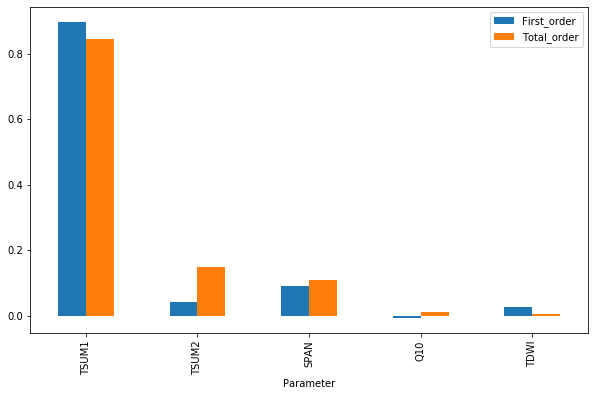

In [61]:
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10,6))
df_sensitivity.plot(kind="bar", ax=axes)

## Second order sensitivities
Second order sensitivities deal with the combined sensitivity of two parameters. The results can therefore most easily be visualized through a matrix 

In [145]:
# Show second-order sensitivities
second_order = np.array(Si['S2'])
pd.DataFrame(second_order, index=problem["names"], columns=problem["names"])

,TSUM1,TSUM2,SPAN,Q10,TDWI
TSUM1,NaN,0.054063,0.082888,0.088671,0.086019
TSUM2,NaN,NaN,0.080061,0.043810,0.052251
SPAN,NaN,NaN,NaN,-0.040885,-0.045121
Q10,NaN,NaN,NaN,NaN,0.013942
TDWI,NaN,NaN,NaN,NaN,NaN


or through an image showing the values in the matrix values graphically. From the results, it is clear that the second order interactions are small as all indices have a value < 0.1.

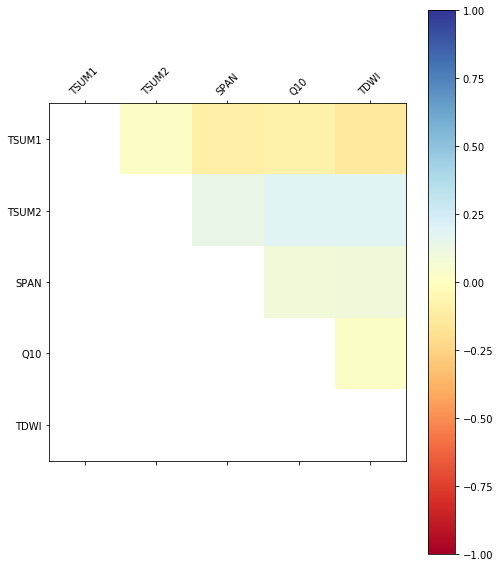

In [126]:
# Visualise second-order sensitivities
fig, axes = plt.subplots(figsize=(8,10))
aximage = axes.matshow(second_order, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
cbar = fig.colorbar(aximage)
aximage.axes.set_xticks(range(len(problem["names"])))
aximage.axes.set_xticklabels(problem["names"], rotation=45)
r = aximage.axes.set_yticklabels([""] + problem["names"])

## Explanation
The background of the sensitivity of sugarbeet yield to TSUM1 is related to the fact that a larger TSUM1 means that the crop will remain in its vegetative stage for a longer period. Given that there is a fixed harvest date this means that the time available for accumulating sugar in the beet root is shorter and thus simulated yields are lower.  Apparently, the other parameters that are part of the analysis do not have large impact within the selected ranges and thus TSUM1 dominates in terms of sensitivity over the other parameters.

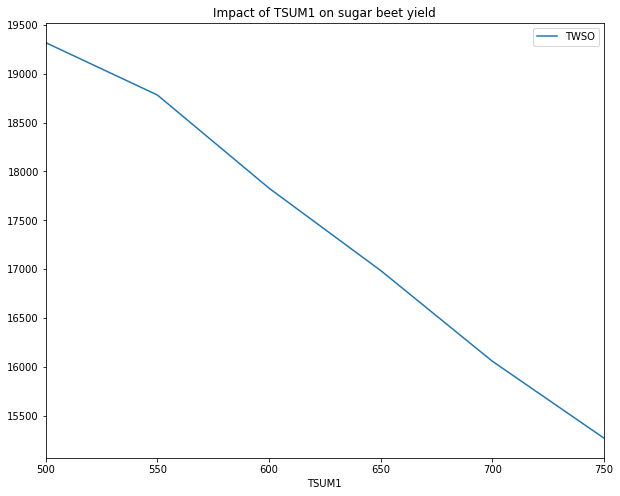

In [152]:
TSUM1_values = list(range(500, 800, 50))
results = []
for tsum1 in TSUM1_values:
    params.clear_override()
    params.set_override("TSUM1", tsum1)
    wofost = Wofost71_PP(params, wdp, agro)
    wofost.run_till_terminate()
    r = wofost.get_summary_output()
    results.append(r[0][target_variable])

df = pd.DataFrame({"TSUM1": TSUM1_values,
                   target_variable: results}
                 ).set_index("TSUM1")
r = df.plot(title="Impact of TSUM1 on sugar beet yield", figsize=(10,8))